In [67]:
import numpy as np
import pandas as pd
import json
import shap
import matplotlib.pyplot as plt
from matplotlib import rc
from colour import Color
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import collections
import pickle

colors = ['#3f7f93','#da3b46','#F6AE2D', '#98b83b', '#825FC3']
cmp_5 = LinearSegmentedColormap.from_list('my_list', [Color(c1).rgb for c1 in colors], N=len(colors))

seed = 42

In [68]:
def abs_shap(df_shap, df, shap_plot, names, class_names, cmp):
    ''' A function to plot the bar plot for the mean abs SHAP values
        arguments:
            df_shap: the dataframe of the SHAP values
            df: the dataframe for the feature values for which the SHAP values have been determined
            shap_plot: The name of the output file for the plot
            names: The names of the variables
            class_names: names of the classes
            cmp: the colour map
    '''
    rc('text', usetex=True)
    plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
    plt.figure(figsize=(5,5))
    shap.summary_plot(df_shap, df, color=cmp, class_names=class_names, class_inds='original', plot_size=(5,5), show=False)#, feature_names=names)
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='lower right', fontsize=15)
    plt.xlabel(r'$\overline{|S_v|}$', fontsize=15)
    ax = plt.gca()
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
    ax.spines["left"].set_visible(True)
    vals = ax.get_xticks()
    ax.tick_params(axis='both', which='major', labelsize=15)
    for tick in vals:
        ax.axvline(x=tick, linestyle='dashed', alpha=0.7, color='#808080', zorder=0, linewidth=0.5)
    plt.tight_layout()
    plt.savefig(shap_plot, dpi=300)
    rc('text', usetex=False)
    
def get_mclass(i, df_array, weight_array, ps_exp_class, seed=seed):
    """ This function is used to create the confusion matrix
        arguments:
            i: integer corresponding to the class number
            df_array: the array of the dataframes of the different classes
            weight_array: the array of the weights for the different classes
            ps_exp_class: the collection of the pseudo experiment events
            seed: the seed for the random number generator
        returns:
            nevents: the number of events
            sif: the significance
    """
    mclass = []
    nchannels = len(df_array)
    for j in range(nchannels):
        mclass.append(collections.Counter(classifier.predict(df_array[j].iloc[:,:-2].values))[i]/len(df_array[j])*weight_array[j]/weight_array[i])

    sig = np.sqrt(ps_exp_class[i])*mclass[i]/np.sum(mclass)
    nevents = np.round(ps_exp_class[i]/np.sum(mclass)*np.array(mclass)).astype(int)
    if nchannels == 5: print('sig: {:2.2f}, klam events: {}, hhsm events: {}, tth events: {}, bbh events: {}, bbxaa events: {}'.format(sig, nevents[4], nevents[3], nevents[2], nevents[1], nevents[0]))
    if nchannels == 4: print('sig: {:2.2f}, hhsm events: {}, tth events: {}, bbh events: {}, bbxaa events: {}'.format(sig, nevents[3], nevents[2], nevents[1], nevents[0]))
    if nchannels == 2: print('sig: {:2.2f}, ku events: {}, hhsm events: {}'.format(sig, nevents[1], nevents[0]))
    return nevents, sig 

In [71]:
prefix = '../WORK/klm1/'

df_sig_test = pd.read_json(prefix+'test_files/sig_test.json')
df_bkg_test = pd.read_json(prefix+'test_files/bkg_test.json')
df_bbh_test = pd.read_json(prefix+'test_files/bbh_test.json')
df_tth_test = pd.read_json(prefix+'test_files/tth_test.json')
df_bbxaa_test = pd.read_json(prefix+'test_files/bbxaa_test.json')

X_shap = pd.read_json(prefix+'shapley_files/shapley_X.json')

with open(prefix+'shapley_files/shapley_values.json', 'r') as f:
    shapley_values = json.load(f)['shap_values']
shapley_values = [np.array(elem) for elem in shapley_values]

weight_sig = df_sig_test['weight'].sum()
weight_bkg = df_bkg_test['weight'].mean()
weight_bbh = df_bbh_test['weight'].mean()
weight_tth = df_tth_test['weight'].mean()
weight_bbxaa = df_bbxaa_test['weight'].mean()

classifier = pickle.load(open(prefix+'hbb-BDT-5class-hhsm-klm1.csv.pickle.dat', 'rb'))

with open(prefix+'test_files/weights.json', 'r') as f:
    weights = json.load(f)

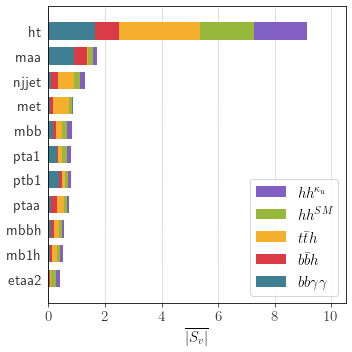

In [70]:
class_names = [r'$bb\gamma\gamma$', r'$b\bar{b}h$', r'$t\bar{t}h$', r'$hh^{SM}$', r'$hh^{\kappa_u}$']
names = list(df_bbxaa_test.columns)[:-2]
shap_plot = '../plots/shap-klm1.pdf'

abs_shap(shapley_values, X_shap, shap_plot, names, class_names, cmp=cmp_5)

In [72]:
df_array = [df_bbxaa_test, df_bbh_test, df_tth_test, df_bkg_test, df_sig_test]
weight_array = [weights['weight_bbxaa']*1.5, weights['weight_bbh'], 
                weights['weight_tth']*1.2, weights['weight_bkg']*1.72, weights['weight_sig']*1.28]

ps_exp_class = collections.Counter(classifier.predict(pd.concat([df_array[4].iloc[:,:-2].sample(n=round(weight_array[4]), random_state=seed, replace=True),
                                                                 df_array[3].iloc[:,:-2].sample(n=round(weight_array[3]), random_state=seed, replace=True),
                                                                 df_array[2].iloc[:,:-2].sample(n=round(weight_array[2]), random_state=seed, replace=True),
                                                                 df_array[1].iloc[:,:-2].sample(n=round(weight_array[1]), random_state=seed, replace=True),
                                                                 df_array[0].iloc[:,:-2].sample(n=round(weight_array[0]), random_state=seed, replace=True)]).values))

nevents_ku, sig_ku = get_mclass(4, df_array, weight_array, ps_exp_class)
nevents_hhsm, sig_hhsm = get_mclass(3, df_array, weight_array, ps_exp_class)
nevents_tth, sig_tth = get_mclass(2, df_array, weight_array, ps_exp_class)
nevents_bbh, sig_bbh = get_mclass(1, df_array, weight_array, ps_exp_class)
nevents_bbxaa, sig_bbxaa = get_mclass(0, df_array, weight_array, ps_exp_class)
confusion = np.column_stack((nevents_ku, nevents_hhsm, nevents_tth, nevents_bbh, nevents_bbxaa))

sig: 8.76, ku events: 340, hhsm events: 97, tth events: 434, bbh events: 75, bbxaa events: 566
sig: 2.74, ku events: 372, hhsm events: 109, tth events: 408, bbh events: 83, bbxaa events: 617
sig: 55.58, ku events: 64, hhsm events: 18, tth events: 3535, bbh events: 39, bbxaa events: 389
sig: 14.01, ku events: 185, hhsm events: 54, tth events: 249, bbh events: 2333, bbxaa events: 24914
sig: 297.95, ku events: 21, hhsm events: 5, tth events: 44, bbh events: 442, bbxaa events: 89282
